In [1]:
#from pandas import read_csv
from pandas import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

<ipython-input-1-dfda4ad542f4>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from warnings import simplefilter
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression   
from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
#     ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
simplefilter("ignore", FutureWarning)
%matplotlib inline

# EPS and STD predictions
- we will first have to predict the earnings of the companies using linear regression since 
1. Analyst estimates data for the stocks in the study period was not available from a reliable source.
2. Using a time series model like ARIMA: ARIMA model can be used to predict earnings based on previous earnings, only when the time series formed from previous lagged earnings is stationary(without trend and seasonality). In our case, the series was not stationary, hence ARIMA could not be used.

## Data preprocessing

In [3]:
fundamentals = pd.read_csv('../dataset/fundamentals_filtered.csv')


In [4]:
fundamentals_list = fundamentals['ticker'].unique().tolist()

In [5]:
# we want only the epsusd, calendar and Ticker columns left
data = pd.DataFrame()

In [6]:
data.dtypes

Series([], dtype: object)

In [7]:
# read them into the data dataframe
data['ticker'] = fundamentals['ticker']
data['date'] = fundamentals['calendardate']
data['eps'] = fundamentals['epsusd']


In [8]:
data

,ticker,date,eps
0,ZSAN,2020-09-30,-0.11
1,ZSAN,2020-06-30,-0.14
2,ZSAN,2020-03-31,-0.24
3,ZSAN,2019-12-31,-0.45
4,ZSAN,2019-09-30,-0.55
...,...,...,...
19384,AAME,2016-03-31,0.04
19385,AAME,2015-12-31,0.00
19386,AAME,2015-09-30,0.01
19387,AAME,2015-06-30,0.16


In [9]:
#save the quarter dates into column_name
column_name = data['date'].unique().tolist()
column_name

['2020-09-30',
 '2020-06-30',
 '2020-03-31',
 '2019-12-31',
 '2019-09-30',
 '2019-06-30',
 '2019-03-31',
 '2018-12-31',
 '2018-09-30',
 '2018-06-30',
 '2018-03-31',
 '2017-12-31',
 '2017-09-30',
 '2017-06-30',
 '2017-03-31',
 '2016-12-31',
 '2016-09-30',
 '2016-06-30',
 '2016-03-31',
 '2015-12-31',
 '2015-09-30',
 '2015-06-30',
 '2015-03-31']

In [10]:
#save the Ticker
Ticker = data['ticker'].unique()
len(Ticker)


843

In [11]:
data_ticker = data['ticker'].unique()
data_ticker = data_ticker.tolist()
data_ticker

['ZSAN',
 'ZNOG',
 'ZIVO',
 'ZGNX',
 'ZEUS',
 'ZAGG',
 'YEWB',
 'XXII',
 'XTNT',
 'XSPA',
 'XONE',
 'XENE',
 'XELB',
 'WYY',
 'WWR',
 'WVVI',
 'WVFC',
 'WTT',
 'WSTL',
 'WSTG',
 'WNEB',
 'WLFC',
 'WLDN',
 'WHLR',
 'WHLM',
 'WHF',
 'WDDD',
 'WATT',
 'VXRT',
 'VUZI',
 'VTNR',
 'VPG',
 'VOXX',
 'VNRX',
 'VIVE',
 'VIRC',
 'VIDE',
 'VGZ',
 'VERU',
 'VEC',
 'VCYT',
 'VCRA',
 'VCEL',
 'VBTX',
 'VBFC',
 'VASO',
 'VALU',
 'VABK',
 'UWHR',
 'UUU',
 'UTI',
 'USNU',
 'USIO',
 'USAP',
 'USAK',
 'URG',
 'UPLD',
 'UONE',
 'UNB',
 'UNAM',
 'UMH',
 'ULBI',
 'UG',
 'UFPT',
 'UEC',
 'UCTT',
 'UBOH',
 'UBFO',
 'UBCP',
 'UAMY',
 'TZOO',
 'TWIN',
 'TSRI',
 'TSQ',
 'TSBK',
 'TRXC',
 'TRVN',
 'TRUP',
 'TRNS',
 'TPVG',
 'TPCS',
 'TOMZ',
 'TOFB',
 'TNXP',
 'TNLX',
 'TMQ',
 'TMBR',
 'TLYS',
 'TKOI',
 'TIPT',
 'TIKK',
 'THMO',
 'THM',
 'TGLS',
 'TGHI',
 'TGEN',
 'TGC',
 'TESS',
 'TENX',
 'TELL',
 'TCON',
 'TCI',
 'TCFC',
 'TBK',
 'TAYD',
 'TAT',
 'TAIT',
 'TACO',
 'SYNL',
 'SYNC',
 'SYN',
 'SWKH',
 'SVT',
 'SVBI'

In [12]:
#dataframe for stocks eps
tickers = data_ticker
stocks_eps = (
    (pd.concat(
        [pd.read_csv(f"../dataset/eps/{ticker}.csv")[
            'eps'
        ].rename(ticker)
        for ticker in tickers],
        axis=1,
        sort=True)
    )
)

stocks_eps  = stocks_eps.loc[:,~stocks_eps.columns.duplicated()]

In [13]:
stocks_eps['date'] = pd.DataFrame(column_name)

In [14]:
stocks_eps_list = stocks_eps.columns.to_list()

In [15]:
original_date = list(data.date.unique())
original_date

['2020-09-30',
 '2020-06-30',
 '2020-03-31',
 '2019-12-31',
 '2019-09-30',
 '2019-06-30',
 '2019-03-31',
 '2018-12-31',
 '2018-09-30',
 '2018-06-30',
 '2018-03-31',
 '2017-12-31',
 '2017-09-30',
 '2017-06-30',
 '2017-03-31',
 '2016-12-31',
 '2016-09-30',
 '2016-06-30',
 '2016-03-31',
 '2015-12-31',
 '2015-09-30',
 '2015-06-30',
 '2015-03-31']

In [16]:
#set date as the index
stocks_eps.set_index('date')

,ZSAN,ZNOG,ZIVO,ZGNX,ZEUS,ZAGG,YEWB,XXII,XTNT,XSPA,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
date,,,,,,,,,,,,,,,,,,,,,
2020-09-30,-0.11,-0.01,-0.01,-1.08,-0.13,0.21,0.02,-0.03,-0.100,-0.100,...,-0.10,0.79,-1.140,0.00,-0.510,-0.01,-0.330,-0.08,-0.04,0.09
2020-06-30,-0.14,-0.01,0.00,-0.96,-0.56,-0.11,0.01,-0.04,-0.190,-1.510,...,-0.08,0.67,-1.680,0.00,-0.560,0.00,-0.730,-0.14,-0.02,0.31
2020-03-31,-0.24,-0.01,-0.01,-0.54,0.05,-2.54,0.00,-0.03,-0.190,-1.740,...,-0.20,-0.14,-2.200,-0.01,-0.490,-0.01,-0.830,-0.52,-0.03,-0.40
2019-12-31,-0.45,-0.01,-0.01,-1.20,-0.07,0.86,-0.04,-0.05,-0.130,6.000,...,-0.18,0.72,-3.800,0.00,-0.510,-0.01,-0.690,-0.29,-0.02,0.06
2019-09-30,-0.55,-0.02,-0.01,-6.75,0.05,0.30,0.02,-0.08,-0.140,-5.040,...,-0.16,0.89,-9.000,0.00,-0.520,0.00,-0.760,-0.35,-0.03,-0.07
2019-06-30,-0.55,-0.02,-0.01,-0.89,0.18,-0.18,0.03,-0.06,-0.150,-9.660,...,-0.16,0.92,-10.000,-0.01,-1.090,0.00,-1.140,-0.49,-0.05,-0.22
2019-03-31,-0.79,-0.03,-0.02,-0.83,0.18,-0.50,0.01,-0.02,-0.210,-4.830,...,-0.17,0.83,-17.600,-0.01,-0.790,-0.01,-1.860,-0.39,-0.02,0.20
2018-12-31,-0.81,-0.52,-0.01,-0.49,-0.12,0.52,-0.06,-0.07,-4.780,-9.600,...,-0.17,0.75,1.800,-0.01,-0.900,-0.01,-1.800,-0.42,0.02,0.01
2018-09-30,-0.68,0.02,-0.03,-1.08,1.01,0.52,-0.01,0.05,-0.240,-6.600,...,-0.21,0.86,-14.200,0.00,-0.430,-0.01,-1.980,-0.34,-0.02,0.04


In [17]:
# check for nulls
print(stocks_eps.isnull().sum().sum())
null = pd.DataFrame(stocks_eps.isnull().sum())
null

52


,0
ZSAN,0
ZNOG,0
ZIVO,0
ZGNX,0
ZEUS,0
...,...
ABIO,0
ABEO,0
ABCP,0
AAME,0


In [18]:
#backfill the null with ffill because we are assuming that we do not know the next data, so we can't use bfill
stocks_eps = stocks_eps.fillna(method='ffill')

In [19]:
stocks_eps.isnull().sum().sum()

7

In [20]:
nan_cols = [i for i in stocks_eps.columns if stocks_eps[i].isnull().any()]
nan_cols

['SRGZ', 'MATN', 'ARTW']

In [21]:
#the remaining Na we will do a backfill since it doesn't really affect the result much
stocks_eps = stocks_eps.fillna(method='bfill')
stocks_eps.isnull().sum().sum()

0

## Transforming the dataframe


In [22]:
df = stocks_eps

print(df.dtypes)
# we want to make the column into the index and index into the column
df_transposed = df.drop(['date'], axis =1).transpose()
df_transposed
# print(df_transposed.dtypes)

# set date as column name 
# df_transposed = df_transposed.rename(columns=df_transposed.iloc[-1]).drop(['date'])

#remove ticker as index
df_transposed.reset_index(inplace=True)

#rename index as Ticker
df_transposed.rename(columns ={'index': 'Ticker'}, inplace=True)

# this df is for actual eps
# df_transposed = pd.concat([df.date, df_transposed], axis = 1)
df_transposed.columns = ['Ticker' , *df.date]
# print(df_transposed.dtypes)


ZSAN    float64
ZNOG    float64
ZIVO    float64
ZGNX    float64
ZEUS    float64
         ...   
ABIO    float64
ABEO    float64
ABCP    float64
AAME    float64
date     object
Length: 844, dtype: object


In [23]:
df
df_transposed

,Ticker,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,...,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31
0,ZSAN,-0.11,-0.14,-0.24,-0.45,-0.55,-0.55,-0.79,-0.81,-0.68,...,-3.400,-6.800,-8.800,-10.400,-10.800,-13.600,-12.80,-14.40,-12.600,-9.400
1,ZNOG,-0.01,-0.01,-0.01,-0.01,-0.02,-0.02,-0.03,-0.52,0.02,...,-0.100,-0.070,-0.040,-0.040,-0.080,-0.040,-0.02,-0.05,-0.060,-0.070
2,ZIVO,-0.01,0.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.03,...,-0.010,-0.010,-0.010,-0.010,-0.020,-0.010,0.00,-0.01,-0.020,-0.010
3,ZGNX,-1.08,-0.96,-0.54,-1.20,-6.75,-0.89,-0.83,-0.49,-1.08,...,-0.930,-0.860,-0.940,-0.690,-0.760,-0.420,-0.50,-0.65,3.780,-1.200
4,ZEUS,-0.13,-0.56,0.05,-0.07,0.05,0.18,0.18,-0.12,1.01,...,0.420,0.680,-0.190,-0.160,0.320,-0.070,-0.44,-0.05,-1.990,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,ABMC,-0.01,0.00,-0.01,-0.01,0.00,0.00,-0.01,-0.01,-0.01,...,-0.010,0.000,0.000,-0.010,0.000,0.000,-0.01,0.00,-0.010,0.000
839,ABIO,-0.33,-0.73,-0.83,-0.69,-0.76,-1.14,-1.86,-1.80,-1.98,...,-10.619,-8.639,-8.279,-9.179,-7.739,-7.199,-5.04,-5.58,-12.599,-16.378
840,ABEO,-0.08,-0.14,-0.52,-0.29,-0.35,-0.49,-0.39,-0.42,-0.34,...,-0.210,-0.130,-0.190,-0.080,-0.200,-0.170,-0.06,-0.19,-0.160,-0.100
841,ABCP,-0.04,-0.02,-0.03,-0.02,-0.03,-0.05,-0.02,0.02,-0.02,...,-0.030,-0.030,-0.010,-0.020,-0.020,-0.030,-0.02,-0.04,-0.030,-0.030


In [24]:
# rename the column names
# names = ['Ticker', 'Sep-20', 'Jun-20', 'Mar-20', 
#          'Dec-19', 'Sep-19', 'Jun-19','Mar-19', 
#          'Dec-18', 'Sep-18', 'Jun-18', 'Mar-18', 
#          'Dec-17', 'Sep-17','Jun-17', 'Mar-17', 
#          'Dec-16', 'Sep-16', 'Jun-16', 'Mar-16', 
#          'Dec-15','Sep-15', 'Jun-15', 'Mar-15']
# df_transposed = df_transposed.rename(columns=dict(zip(df_transposed.columns,names)))

df_transposed


,Ticker,2020-09-30,2020-06-30,2020-03-31,2019-12-31,2019-09-30,2019-06-30,2019-03-31,2018-12-31,2018-09-30,...,2017-06-30,2017-03-31,2016-12-31,2016-09-30,2016-06-30,2016-03-31,2015-12-31,2015-09-30,2015-06-30,2015-03-31
0,ZSAN,-0.11,-0.14,-0.24,-0.45,-0.55,-0.55,-0.79,-0.81,-0.68,...,-3.400,-6.800,-8.800,-10.400,-10.800,-13.600,-12.80,-14.40,-12.600,-9.400
1,ZNOG,-0.01,-0.01,-0.01,-0.01,-0.02,-0.02,-0.03,-0.52,0.02,...,-0.100,-0.070,-0.040,-0.040,-0.080,-0.040,-0.02,-0.05,-0.060,-0.070
2,ZIVO,-0.01,0.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.03,...,-0.010,-0.010,-0.010,-0.010,-0.020,-0.010,0.00,-0.01,-0.020,-0.010
3,ZGNX,-1.08,-0.96,-0.54,-1.20,-6.75,-0.89,-0.83,-0.49,-1.08,...,-0.930,-0.860,-0.940,-0.690,-0.760,-0.420,-0.50,-0.65,3.780,-1.200
4,ZEUS,-0.13,-0.56,0.05,-0.07,0.05,0.18,0.18,-0.12,1.01,...,0.420,0.680,-0.190,-0.160,0.320,-0.070,-0.44,-0.05,-1.990,0.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,ABMC,-0.01,0.00,-0.01,-0.01,0.00,0.00,-0.01,-0.01,-0.01,...,-0.010,0.000,0.000,-0.010,0.000,0.000,-0.01,0.00,-0.010,0.000
839,ABIO,-0.33,-0.73,-0.83,-0.69,-0.76,-1.14,-1.86,-1.80,-1.98,...,-10.619,-8.639,-8.279,-9.179,-7.739,-7.199,-5.04,-5.58,-12.599,-16.378
840,ABEO,-0.08,-0.14,-0.52,-0.29,-0.35,-0.49,-0.39,-0.42,-0.34,...,-0.210,-0.130,-0.190,-0.080,-0.200,-0.170,-0.06,-0.19,-0.160,-0.100
841,ABCP,-0.04,-0.02,-0.03,-0.02,-0.03,-0.05,-0.02,0.02,-0.02,...,-0.030,-0.030,-0.010,-0.020,-0.020,-0.030,-0.02,-0.04,-0.030,-0.030


# Using functions

In [25]:
def transpose_reverse(data):
    Ticker = data.Ticker.str.replace(' IS Equity','')
    df = data.iloc[::,1:]
    df = df.iloc[:,::-1].T
#     df.columns = Ticker
    df = df.reset_index()
    df['index'] = df['index'].str.replace('-',' 20')
#     df['index'] = pd.to_datetime(df['index'])
    df = df.set_index('index')#.asfreq('Q')
    df.columns = Ticker

    return df

In [26]:
df = transpose_reverse(df_transposed)
df.head()

Ticker,ZSAN,ZNOG,ZIVO,ZGNX,ZEUS,ZAGG,YEWB,XXII,XTNT,XSPA,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
index,,,,,,,,,,,,,,,,,,,,,
2015 2003 2031,-9.4,-0.07,-0.01,-1.20,0.10,0.11,0.02,-0.06,-7.440,-42.000,...,-0.23,0.42,-439.996,-0.11,-9.936,0.00,-16.378,-0.10,-0.03,0.03
2015 2006 2030,-12.6,-0.06,-0.02,3.78,-1.99,0.13,0.04,-0.02,-4.920,-54.001,...,-0.20,0.47,-571.994,-0.12,-5.796,-0.01,-12.599,-0.16,-0.03,0.16
2015 2009 2030,-14.4,-0.05,-0.01,-0.65,-0.05,0.13,0.02,-0.04,-7.680,-72.001,...,0.11,0.47,-351.996,-0.10,-4.347,0.00,-5.580,-0.19,-0.04,0.01
2015 2012 2031,-12.8,-0.02,0.00,-0.50,-0.44,0.18,0.03,-0.04,17.521,102.601,...,-0.24,0.47,-87.999,-0.07,-3.105,-0.01,-5.040,-0.06,-0.02,0.00
2016 2003 2031,-13.6,-0.04,-0.01,-0.42,-0.07,-0.12,0.02,-0.04,-5.640,-16.800,...,-0.24,0.42,-263.997,-0.11,-3.208,0.00,-7.199,-0.17,-0.03,0.04


In [27]:
original_date.reverse()
original_date

['2015-03-31',
 '2015-06-30',
 '2015-09-30',
 '2015-12-31',
 '2016-03-31',
 '2016-06-30',
 '2016-09-30',
 '2016-12-31',
 '2017-03-31',
 '2017-06-30',
 '2017-09-30',
 '2017-12-31',
 '2018-03-31',
 '2018-06-30',
 '2018-09-30',
 '2018-12-31',
 '2019-03-31',
 '2019-06-30',
 '2019-09-30',
 '2019-12-31',
 '2020-03-31',
 '2020-06-30',
 '2020-09-30']

In [28]:
df = df.reset_index()
df['index'] = original_date
df['index'].astype('datetime64[ns]')
df.set_index('index',inplace=True)

In [29]:
df.index = df.index.astype('datetime64[ns]')

In [30]:
df.index

DatetimeIndex(['2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
               '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30'],
              dtype='datetime64[ns]', name='index', freq=None)

In [31]:
df.head()

Ticker,ZSAN,ZNOG,ZIVO,ZGNX,ZEUS,ZAGG,YEWB,XXII,XTNT,XSPA,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
index,,,,,,,,,,,,,,,,,,,,,
2015-03-31,-9.4,-0.07,-0.01,-1.20,0.10,0.11,0.02,-0.06,-7.440,-42.000,...,-0.23,0.42,-439.996,-0.11,-9.936,0.00,-16.378,-0.10,-0.03,0.03
2015-06-30,-12.6,-0.06,-0.02,3.78,-1.99,0.13,0.04,-0.02,-4.920,-54.001,...,-0.20,0.47,-571.994,-0.12,-5.796,-0.01,-12.599,-0.16,-0.03,0.16
2015-09-30,-14.4,-0.05,-0.01,-0.65,-0.05,0.13,0.02,-0.04,-7.680,-72.001,...,0.11,0.47,-351.996,-0.10,-4.347,0.00,-5.580,-0.19,-0.04,0.01
2015-12-31,-12.8,-0.02,0.00,-0.50,-0.44,0.18,0.03,-0.04,17.521,102.601,...,-0.24,0.47,-87.999,-0.07,-3.105,-0.01,-5.040,-0.06,-0.02,0.00
2016-03-31,-13.6,-0.04,-0.01,-0.42,-0.07,-0.12,0.02,-0.04,-5.640,-16.800,...,-0.24,0.42,-263.997,-0.11,-3.208,0.00,-7.199,-0.17,-0.03,0.04


In [32]:
df.dtypes

Ticker
ZSAN    float64
ZNOG    float64
ZIVO    float64
ZGNX    float64
ZEUS    float64
         ...   
ABMC    float64
ABIO    float64
ABEO    float64
ABCP    float64
AAME    float64
Length: 843, dtype: object

# ARIMA and Naive Models to forecast EPS

In [33]:
def tt_split(col):
    # predicting 4 quarters ahead
    col.index = col.index.to_period(freq ='Q')
    
    y_train, y_test = temporal_train_test_split(col, test_size = 4)
#     plot_series(y_train, y_test, labels=["y_train", "y_test"])
#     print(y_train.shape[0], y_test.shape[0])
    fh = np.arange(len(y_test)) + 1
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    return y_train, y_test, fh

In [34]:
def auto_forecast(y_train, y_test, fh, est  = NaiveForecaster(strategy="last"), graph = False):
    # using sktime
    forecaster = est
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    if graph:
        plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    smape = smape_loss(y_pred, y_test)

    return smape#, est

# smape = auto_forecast(y_train,y_test, fh, NaiveForecaster(strategy="last"),graph = True )
# smape

In [35]:
#drop some names that we do not want
names = ['TCON','TMBR', 'TAT', 'BSTC','ZSAN','RCKT','TAT','LLEXQ','WSTL','NTRP','JCAP','RKDA','RMNI','PATI','ZEUS']

df = df.drop(columns=names)


In [36]:
df

Ticker,ZNOG,ZIVO,ZGNX,ZAGG,YEWB,XXII,XTNT,XSPA,XONE,XENE,...,ACRX,ACNB,ACHV,ACFN,ACER,ABMC,ABIO,ABEO,ABCP,AAME
index,,,,,,,,,,,,,,,,,,,,,
2015-03-31,-0.07,-0.01,-1.20,0.11,0.02,-0.06,-7.440,-42.000,-0.53,-0.30,...,-0.23,0.42,-439.996,-0.11,-9.936,0.00,-16.378,-0.10,-0.03,0.03
2015-06-30,-0.06,-0.02,3.78,0.13,0.04,-0.02,-4.920,-54.001,-0.48,0.08,...,-0.20,0.47,-571.994,-0.12,-5.796,-0.01,-12.599,-0.16,-0.03,0.16
2015-09-30,-0.05,-0.01,-0.65,0.13,0.02,-0.04,-7.680,-72.001,-0.70,-0.27,...,0.11,0.47,-351.996,-0.10,-4.347,0.00,-5.580,-0.19,-0.04,0.01
2015-12-31,-0.02,0.00,-0.50,0.18,0.03,-0.04,17.521,102.601,-0.08,-0.27,...,-0.24,0.47,-87.999,-0.07,-3.105,-0.01,-5.040,-0.06,-0.02,0.00
2016-03-31,-0.04,-0.01,-0.42,-0.12,0.02,-0.04,-5.640,-16.800,-0.35,-0.23,...,-0.24,0.42,-263.997,-0.11,-3.208,0.00,-7.199,-0.17,-0.03,0.04
2016-06-30,-0.08,-0.02,-0.76,-0.04,0.03,-0.04,-4.440,-43.200,-0.18,-0.42,...,-0.24,0.49,-505.995,0.09,-3.105,0.00,-7.739,-0.20,-0.02,0.01
2016-09-30,-0.04,-0.01,-0.69,-0.25,0.02,-0.03,-4.800,-20.400,-0.23,-0.51,...,-0.25,0.46,-263.997,0.02,-2.898,-0.01,-9.179,-0.08,-0.02,0.00
2016-12-31,-0.04,-0.01,-0.94,-0.15,-0.03,-0.04,-3.600,-13.800,-0.16,-0.32,...,-0.21,0.43,-417.996,0.01,-2.484,0.00,-8.279,-0.19,-0.01,0.06
2017-03-31,-0.07,-0.01,-0.86,-0.22,0.00,-0.03,-3.480,-20.400,-0.42,-0.42,...,-0.34,0.43,-241.998,-0.01,-1.242,0.00,-8.639,-0.13,-0.03,-0.02


In [37]:
df.isnull().sum().sum()

0

In [38]:
# this cell consists of all the SMAPE losses for all the stocks for the quarters we are concerned with
smape = []
for _, col in df.iteritems(): 

    y_train, y_test, fh = tt_split(col.copy()) 
    print(y_train)
    smape.append(auto_forecast(y_train,y_test, fh,graph = False))


smape[:15]

index
2015Q1   -0.07
2015Q2   -0.06
2015Q3   -0.05
2015Q4   -0.02
2016Q1   -0.04
2016Q2   -0.08
2016Q3   -0.04
2016Q4   -0.04
2017Q1   -0.07
2017Q2   -0.10
2017Q3   -0.03
2017Q4    0.00
2018Q1   -0.11
2018Q2   -0.02
2018Q3    0.02
2018Q4   -0.52
2019Q1   -0.03
2019Q2   -0.02
2019Q3   -0.02
Freq: Q-DEC, Name: ZNOG, dtype: float64
index
2015Q1   -0.01
2015Q2   -0.02
2015Q3   -0.01
2015Q4    0.00
2016Q1   -0.01
2016Q2   -0.02
2016Q3   -0.01
2016Q4   -0.01
2017Q1   -0.01
2017Q2   -0.01
2017Q3   -0.02
2017Q4   -0.03
2018Q1   -0.03
2018Q2   -0.02
2018Q3   -0.03
2018Q4   -0.01
2019Q1   -0.02
2019Q2   -0.01
2019Q3   -0.01
Freq: Q-DEC, Name: ZIVO, dtype: float64
index
2015Q1   -1.20
2015Q2    3.78
2015Q3   -0.65
2015Q4   -0.50
2016Q1   -0.42
2016Q2   -0.76
2016Q3   -0.69
2016Q4   -0.94
2017Q1   -0.86
2017Q2   -0.93
2017Q3   -1.68
2017Q4   -1.17
2018Q1   -0.87
2018Q2   -0.83
2018Q3   -1.08
2018Q4   -0.49
2019Q1   -0.83
2019Q2   -0.89
2019Q3   -6.75
Freq: Q-DEC, Name: ZGNX, dtype: float64
index
2

index
2015Q1    0.11
2015Q2    0.22
2015Q3    0.20
2015Q4    0.20
2016Q1    0.13
2016Q2    0.65
2016Q3    0.15
2016Q4    0.15
2017Q1    0.11
2017Q2    0.23
2017Q3    0.21
2017Q4    0.93
2018Q1    0.15
2018Q2    0.32
2018Q3    0.34
2018Q4    0.25
2019Q1    0.24
2019Q2    0.38
2019Q3    0.44
Freq: Q-DEC, Name: VALU, dtype: float64
index
2015Q1    0.136
2015Q2    0.272
2015Q3    0.308
2015Q4    0.399
2016Q1    0.517
2016Q2    0.580
2016Q3    0.535
2016Q4    0.571
2017Q1    0.662
2017Q2    0.726
2017Q3    0.662
2017Q4    0.435
2018Q1    1.048
2018Q2    0.686
2018Q3    0.810
2018Q4    0.629
2019Q1    0.467
2019Q2    0.790
2019Q3    0.710
Freq: Q-DEC, Name: VABK, dtype: float64
index
2015Q1    0.065
2015Q2    0.065
2015Q3    0.057
2015Q4    0.000
2016Q1    0.047
2016Q2    0.075
2016Q3    0.058
2016Q4    0.038
2017Q1    0.067
2017Q2    0.067
2017Q3    0.058
2017Q4   -0.055
2018Q1    0.010
2018Q2    0.049
2018Q3    0.069
2018Q4    0.137
2019Q1    0.078
2019Q2    0.108
2019Q3    0.118
Freq: Q-D

Freq: Q-DEC, Name: TENX, dtype: float64
index
2015Q1   -0.48
2015Q2   -6.31
2015Q3   -0.61
2015Q4   -0.32
2016Q1   -1.95
2016Q2    0.24
2016Q3   -0.23
2016Q4   -0.09
2017Q1   -0.92
2017Q2   -0.17
2017Q3   -0.12
2017Q4   -0.17
2018Q1   -0.12
2018Q2   -0.17
2018Q3   -0.15
2018Q4   -0.14
2019Q1   -0.16
2019Q2   -0.19
2019Q3   -0.18
Freq: Q-DEC, Name: TELL, dtype: float64
index
2015Q1    -0.02
2015Q2    -0.01
2015Q3    -0.79
2015Q4    -0.17
2016Q1    -0.43
2016Q2     0.51
2016Q3    -0.79
2016Q4     0.37
2017Q1    -0.61
2017Q2    -1.22
2017Q3     0.79
2017Q4    -0.87
2018Q1    -0.05
2018Q2     0.81
2018Q3     2.52
2018Q4    17.44
2019Q1    -0.64
2019Q2    -0.73
2019Q3    -0.89
Freq: Q-DEC, Name: TCI, dtype: float64
index
2015Q1    0.38
2015Q2    0.37
2015Q3    0.28
2015Q4    0.33
2016Q1    0.35
2016Q2    0.38
2016Q3    0.43
2016Q4    0.43
2017Q1    0.51
2017Q2    0.55
2017Q3    0.60
2017Q4   -0.10
2018Q1    0.22
2018Q2    0.42
2018Q3    0.70
2018Q4    0.68
2019Q1    0.70
2019Q2    0.65
2019

index
2015Q1     0.00
2015Q2    -1.00
2015Q3     0.00
2015Q4    -1.00
2016Q1     0.00
2016Q2    -1.00
2016Q3     0.00
2016Q4     0.00
2017Q1     0.00
2017Q2     0.00
2017Q3     0.00
2017Q4     0.00
2018Q1     0.00
2018Q2     0.00
2018Q3     0.00
2018Q4     0.00
2019Q1   -39.00
2019Q2    -0.15
2019Q3    -0.35
Freq: Q-DEC, Name: SMTI, dtype: float64
index
2015Q1    0.49
2015Q2    0.38
2015Q3    0.34
2015Q4    0.37
2016Q1    0.38
2016Q2    0.40
2016Q3    0.40
2016Q4    0.44
2017Q1   -0.15
2017Q2    0.43
2017Q3    0.48
2017Q4    0.19
2018Q1    0.60
2018Q2    0.51
2018Q3    0.56
2018Q4    0.60
2019Q1    0.56
2019Q2    0.68
2019Q3    0.65
Freq: Q-DEC, Name: SMMF, dtype: float64
index
2015Q1   -0.06
2015Q2    0.03
2015Q3   -0.07
2015Q4   -0.13
2016Q1   -0.15
2016Q2   -0.16
2016Q3   -0.04
2016Q4   -0.13
2017Q1   -0.04
2017Q2   -0.15
2017Q3   -0.04
2017Q4    0.03
2018Q1    0.00
2018Q2    0.06
2018Q3   -0.05
2018Q4   -0.06
2019Q1   -0.12
2019Q2   -0.06
2019Q3    0.04
Freq: Q-DEC, Name: SMIT, dty

index
2015Q1    0.07
2015Q2   -0.49
2015Q3   -0.14
2015Q4   -0.14
2016Q1    0.00
2016Q2   -0.56
2016Q3    0.07
2016Q4    0.15
2017Q1    0.28
2017Q2   -0.28
2017Q3   -0.17
2017Q4   -0.21
2018Q1   -0.13
2018Q2   -0.53
2018Q3   -0.29
2018Q4   -0.08
2019Q1    0.36
2019Q2   -0.22
2019Q3   -0.09
Freq: Q-DEC, Name: RELV, dtype: float64
index
2015Q1   -0.16
2015Q2   -0.17
2015Q3   -0.10
2015Q4   -0.18
2016Q1   -0.23
2016Q2   -0.02
2016Q3   -0.23
2016Q4   -0.20
2017Q1   -0.11
2017Q2   -0.01
2017Q3   -0.01
2017Q4    0.13
2018Q1    0.04
2018Q2    0.13
2018Q3    0.03
2018Q4   -0.02
2019Q1   -0.08
2019Q2   -0.50
2019Q3    0.01
Freq: Q-DEC, Name: RELL, dtype: float64
index
2015Q1   -0.04
2015Q2    0.02
2015Q3   -0.04
2015Q4   -0.26
2016Q1   -0.50
2016Q2   -0.41
2016Q3   -0.14
2016Q4    0.03
2017Q1    0.03
2017Q2    0.04
2017Q3    0.06
2017Q4   -0.09
2018Q1    0.10
2018Q2    0.08
2018Q3    0.09
2018Q4   -0.12
2019Q1    0.18
2019Q2    0.18
2019Q3    0.15
Freq: Q-DEC, Name: REI, dtype: float64
index
20

Freq: Q-DEC, Name: PFBX, dtype: float64
index
2015Q1    0.284
2015Q2    0.276
2015Q3    0.298
2015Q4    0.247
2016Q1    0.233
2016Q2    0.196
2016Q3    0.240
2016Q4    0.259
2017Q1    0.272
2017Q2    0.296
2017Q3    0.264
2017Q4    0.280
2018Q1    0.384
2018Q2    0.330
2018Q3    0.380
2018Q4    0.390
2019Q1    0.420
2019Q2    0.400
2019Q3    0.430
Freq: Q-DEC, Name: PFBI, dtype: float64
index
2015Q1   -0.03
2015Q2   -0.06
2015Q3   -0.06
2015Q4   -0.04
2016Q1   -0.03
2016Q2   -0.02
2016Q3   -0.04
2016Q4   -0.04
2017Q1   -0.02
2017Q2   -0.03
2017Q3    0.00
2017Q4   -0.01
2018Q1   -0.03
2018Q2    0.00
2018Q3   -0.03
2018Q4   -0.01
2019Q1   -0.01
2019Q2   -0.01
2019Q3   -0.01
Freq: Q-DEC, Name: PEYE, dtype: float64
index
2015Q1   -0.18
2015Q2   -0.01
2015Q3    0.09
2015Q4    0.01
2016Q1   -0.33
2016Q2   -0.71
2016Q3   -0.13
2016Q4    0.03
2017Q1   -0.06
2017Q2   -0.10
2017Q3   -0.17
2017Q4    0.03
2018Q1    0.01
2018Q2    0.05
2018Q3    0.02
2018Q4   -0.20
2019Q1   -0.06
2019Q2    0.02
201

index
2015Q1    0.28
2015Q2    0.03
2015Q3    0.27
2015Q4    0.72
2016Q1   -0.04
2016Q2    0.12
2016Q3    0.27
2016Q4    0.67
2017Q1    0.04
2017Q2    0.07
2017Q3    0.21
2017Q4    0.50
2018Q1   -0.03
2018Q2    0.01
2018Q3    0.12
2018Q4   -0.78
2019Q1   -0.10
2019Q2    0.08
2019Q3   -0.23
Freq: Q-DEC, Name: NWHM, dtype: float64
index
2015Q1    0.367
2015Q2    0.353
2015Q3    0.320
2015Q4    0.020
2016Q1    0.340
2016Q2    0.340
2016Q3    0.100
2016Q4    0.387
2017Q1    0.380
2017Q2    0.440
2017Q3    0.470
2017Q4    0.030
2018Q1    0.500
2018Q2    0.570
2018Q3    0.590
2018Q4    0.530
2019Q1    0.510
2019Q2    0.560
2019Q3    0.620
Freq: Q-DEC, Name: NWFL, dtype: float64
index
2015Q1   -95.573
2015Q2   -64.795
2015Q3   -85.854
2015Q4   -79.374
2016Q1   -82.614
2016Q2   -97.193
2016Q3   -66.415
2016Q4   -27.538
2017Q1   -27.538
2017Q2   -23.758
2017Q3    -7.739
2017Q4    -0.900
2018Q1    -6.479
2018Q2    -6.120
2018Q3    -6.659
2018Q4    -8.819
2019Q1    -9.359
2019Q2    -6.299
2019Q3 

index
2015Q1   -0.01
2015Q2    0.01
2015Q3    0.01
2015Q4   -0.35
2016Q1    0.09
2016Q2   -0.11
2016Q3   -1.27
2016Q4   -0.88
2017Q1   -0.21
2017Q2   -0.14
2017Q3   -0.09
2017Q4   -0.05
2018Q1   -0.09
2018Q2   -0.05
2018Q3    0.01
2018Q4   -0.59
2019Q1    0.05
2019Q2    0.16
2019Q3   -0.60
Freq: Q-DEC, Name: MNTX, dtype: float64
index
2015Q1   -0.09
2015Q2   -0.09
2015Q3   -0.06
2015Q4   -0.09
2016Q1   -0.11
2016Q2   -0.10
2016Q3   -0.08
2016Q4   -0.04
2017Q1   -0.09
2017Q2   -0.08
2017Q3   -0.11
2017Q4   -0.05
2018Q1   -0.12
2018Q2   -0.08
2018Q3   -0.16
2018Q4   -0.01
2019Q1   -0.11
2019Q2   -0.09
2019Q3   -0.05
Freq: Q-DEC, Name: MNOV, dtype: float64
index
2015Q1    0.24
2015Q2    0.24
2015Q3    0.24
2015Q4    0.19
2016Q1    0.16
2016Q2    0.17
2016Q3    0.15
2016Q4    0.14
2017Q1    0.13
2017Q2    0.12
2017Q3    0.10
2017Q4   -0.10
2018Q1    0.08
2018Q2    0.05
2018Q3    0.05
2018Q4    0.03
2019Q1    0.04
2019Q2    0.03
2019Q3    0.05
Freq: Q-DEC, Name: MN, dtype: float64
index
201

index
2015Q1    0.01
2015Q2    0.08
2015Q3    0.03
2015Q4   -0.02
2016Q1    0.02
2016Q2    0.00
2016Q3    0.01
2016Q4   -0.12
2017Q1    0.05
2017Q2   -0.04
2017Q3    0.05
2017Q4   -0.02
2018Q1    0.03
2018Q2   -0.01
2018Q3    0.21
2018Q4    0.00
2019Q1    0.00
2019Q2    0.01
2019Q3    0.25
Freq: Q-DEC, Name: LEAT, dtype: float64
index
2015Q1   -0.34
2015Q2   -0.73
2015Q3   -0.69
2015Q4   -0.42
2016Q1   -0.59
2016Q2    1.20
2016Q3   -0.41
2016Q4   -0.31
2017Q1   -0.50
2017Q2   -0.44
2017Q3   -0.33
2017Q4   -0.25
2018Q1   -0.26
2018Q2   -0.25
2018Q3   -0.24
2018Q4   -0.19
2019Q1   -0.40
2019Q2   -0.26
2019Q3   -0.17
Freq: Q-DEC, Name: LEAF, dtype: float64
index
2015Q1   -0.15
2015Q2   -0.12
2015Q3    0.37
2015Q4    0.80
2016Q1   -0.31
2016Q2   -0.08
2016Q3    0.45
2016Q4    1.04
2017Q1   -0.09
2017Q2   -0.14
2017Q3    0.30
2017Q4    0.09
2018Q1   -0.70
2018Q2   -0.30
2018Q3    0.29
2018Q4    0.52
2019Q1   -0.24
2019Q2   -0.56
2019Q3   -0.66
Freq: Q-DEC, Name: LCUT, dtype: float64
index
2

index
2015Q1    0.46
2015Q2    0.50
2015Q3    0.51
2015Q4    0.50
2016Q1    0.54
2016Q2    0.57
2016Q3    0.55
2016Q4    0.66
2017Q1    0.43
2017Q2    0.61
2017Q3    0.72
2017Q4    0.38
2018Q1    0.71
2018Q2    0.67
2018Q3    0.61
2018Q4    0.32
2019Q1    0.56
2019Q2    0.60
2019Q3    0.63
Freq: Q-DEC, Name: INBK, dtype: float64
index
2015Q1    3.54
2015Q2    1.65
2015Q3    1.89
2015Q4    1.00
2016Q1    0.09
2016Q2    0.99
2016Q3    1.28
2016Q4    1.11
2017Q1    0.29
2017Q2    0.33
2017Q3    0.11
2017Q4   -2.33
2018Q1    0.18
2018Q2   -4.65
2018Q3   -2.16
2018Q4   -0.30
2019Q1   -0.60
2019Q2    0.18
2019Q3    0.07
Freq: Q-DEC, Name: IMH, dtype: float64
index
2015Q1   -0.8
2015Q2   -0.5
2015Q3   -0.9
2015Q4    0.1
2016Q1   -0.9
2016Q2   -0.3
2016Q3   -0.6
2016Q4    0.4
2017Q1   -0.5
2017Q2   -0.3
2017Q3   -0.2
2017Q4    1.0
2018Q1   -0.5
2018Q2    0.0
2018Q3   -1.4
2018Q4   -1.6
2019Q1   -3.1
2019Q2   -1.3
2019Q3   -0.9
Freq: Q-DEC, Name: IMBI, dtype: float64
index
2015Q1   -0.11
2015Q2

index
2015Q1    0.09
2015Q2    0.01
2015Q3   -0.01
2015Q4   -0.04
2016Q1    0.01
2016Q2    0.10
2016Q3    0.03
2016Q4   -0.07
2017Q1    0.08
2017Q2    0.02
2017Q3    0.08
2017Q4   -0.10
2018Q1    0.10
2018Q2    0.07
2018Q3   -0.01
2018Q4    0.01
2019Q1    0.01
2019Q2    0.03
2019Q3    0.05
Freq: Q-DEC, Name: GORO, dtype: float64
index
2015Q1    0.01
2015Q2    0.00
2015Q3    0.27
2015Q4   -0.01
2016Q1   -0.02
2016Q2    0.01
2016Q3   -0.02
2016Q4   -0.03
2017Q1    0.01
2017Q2   -0.02
2017Q3    0.00
2017Q4   -0.05
2018Q1    0.01
2018Q2    0.00
2018Q3   -0.08
2018Q4    0.03
2019Q1    0.04
2019Q2    0.02
2019Q3    0.00
Freq: Q-DEC, Name: GNSS, dtype: float64
index
2015Q1   -5.12
2015Q2   -3.44
2015Q3   -2.96
2015Q4   -2.88
2016Q1   -2.80
2016Q2   -3.12
2016Q3   -3.60
2016Q4   -4.56
2017Q1   -3.84
2017Q2   -4.32
2017Q3   -4.72
2017Q4   -2.96
2018Q1   -1.76
2018Q2   -0.40
2018Q3   -0.72
2018Q4    0.08
2019Q1   -1.20
2019Q2   -0.42
2019Q3   -0.28
Freq: Q-DEC, Name: GNCA, dtype: float64
index
2

index
2015Q1    0.16
2015Q2    0.17
2015Q3    0.18
2015Q4    0.16
2016Q1    0.14
2016Q2    0.12
2016Q3    0.22
2016Q4    0.28
2017Q1    0.23
2017Q2    0.18
2017Q3    0.18
2017Q4    0.23
2018Q1    0.67
2018Q2    0.30
2018Q3    0.27
2018Q4    0.20
2019Q1    0.19
2019Q2    0.33
2019Q3    0.25
Freq: Q-DEC, Name: FFNW, dtype: float64
index
2015Q1    0.02
2015Q2   -0.02
2015Q3   -0.01
2015Q4   -0.05
2016Q1   -0.04
2016Q2   -0.06
2016Q3   -0.04
2016Q4   -0.09
2017Q1   -0.06
2017Q2   -0.11
2017Q3   -0.15
2017Q4   -0.79
2018Q1   -0.09
2018Q2   -0.14
2018Q3   -0.14
2018Q4   -0.15
2019Q1   -0.13
2019Q2   -0.24
2019Q3   -0.09
Freq: Q-DEC, Name: FENC, dtype: float64
index
2015Q1    0.00
2015Q2    0.10
2015Q3   -0.01
2015Q4    0.03
2016Q1    0.00
2016Q2   -0.08
2016Q3   -0.12
2016Q4    0.04
2017Q1   -0.39
2017Q2    0.07
2017Q3   -0.17
2017Q4   -1.17
2018Q1   -1.42
2018Q2    0.00
2018Q3    0.01
2018Q4   -0.03
2019Q1   -0.26
2019Q2   -0.07
2019Q3   -0.54
Freq: Q-DEC, Name: FEIM, dtype: float64
index
2

Freq: Q-DEC, Name: EBMT, dtype: float64
index
2015Q1    0.40
2015Q2    0.02
2015Q3   -0.53
2015Q4    0.10
2016Q1   -0.03
2016Q2    0.38
2016Q3    0.73
2016Q4    0.22
2017Q1    0.22
2017Q2    0.15
2017Q3    0.48
2017Q4    0.02
2018Q1   -0.30
2018Q2    0.14
2018Q3    0.07
2018Q4   -0.79
2019Q1    0.72
2019Q2   -0.01
2019Q3    0.30
Freq: Q-DEC, Name: EARN, dtype: float64
index
2015Q1   -0.16
2015Q2    0.03
2015Q3    0.01
2015Q4   -0.04
2016Q1   -0.30
2016Q2    0.10
2016Q3    0.04
2016Q4   -0.18
2017Q1   -0.04
2017Q2    0.07
2017Q3   -0.03
2017Q4   -0.59
2018Q1   -0.18
2018Q2   -0.12
2018Q3   -0.19
2018Q4   -0.87
2019Q1   -0.42
2019Q2   -0.07
2019Q3   -0.16
Freq: Q-DEC, Name: DXYN, dtype: float64
index
2015Q1   -0.01
2015Q2   -0.02
2015Q3   -0.11
2015Q4   -0.03
2016Q1    0.00
2016Q2    0.00
2016Q3   -0.09
2016Q4    0.03
2017Q1   -0.12
2017Q2   -0.08
2017Q3   -0.12
2017Q4   -0.07
2018Q1   -0.06
2018Q2   -0.02
2018Q3   -0.04
2018Q4   -0.15
2019Q1   -0.06
2019Q2    0.00
2019Q3   -0.14
Freq: Q

index
2015Q1   -1.15
2015Q2   -0.65
2015Q3   -0.70
2015Q4   -0.50
2016Q1   -0.60
2016Q2   -0.65
2016Q3   -1.15
2016Q4   -0.80
2017Q1   -0.95
2017Q2   -0.50
2017Q3   -0.85
2017Q4   -0.80
2018Q1   -0.70
2018Q2   -0.50
2018Q3   -0.55
2018Q4    0.25
2019Q1   -0.22
2019Q2   -0.03
2019Q3   -1.35
Freq: Q-DEC, Name: CRMD, dtype: float64
index
2015Q1    -8.55
2015Q2   -14.65
2015Q3   -59.05
2015Q4   -31.30
2016Q1    -5.70
2016Q2     0.41
2016Q3    -2.32
2016Q4    -4.39
2017Q1    -1.61
2017Q2    -1.45
2017Q3    -1.67
2017Q4    -2.87
2018Q1    -2.78
2018Q2    -2.22
2018Q3     0.13
2018Q4     0.13
2019Q1     0.13
2019Q2     0.20
2019Q3    -0.01
Freq: Q-DEC, Name: CRK, dtype: float64
index
2015Q1   -0.01
2015Q2   -0.01
2015Q3   -0.02
2015Q4   -0.01
2016Q1   -0.03
2016Q2   -0.03
2016Q3   -0.03
2016Q4   -0.02
2017Q1   -0.03
2017Q2   -0.03
2017Q3   -0.02
2017Q4   -0.03
2018Q1   -0.03
2018Q2   -0.02
2018Q3   -0.06
2018Q4   -0.02
2019Q1   -0.02
2019Q2   -0.02
2019Q3   -0.03
Freq: Q-DEC, Name: CRGS, dtyp

Freq: Q-DEC, Name: CDTX, dtype: float64
index
2015Q1     3.137
2015Q2    -8.627
2015Q3    13.660
2015Q4     4.510
2016Q1   -13.791
2016Q2     9.412
2016Q3     2.418
2016Q4     4.706
2017Q1    -4.750
2017Q2     0.400
2017Q3    -0.110
2017Q4     0.210
2018Q1     0.050
2018Q2     0.230
2018Q3     0.210
2018Q4    -0.100
2019Q1    -0.010
2019Q2    -0.120
2019Q3    -0.180
Freq: Q-DEC, Name: CDOR, dtype: float64
index
2015Q1   -0.19
2015Q2   -0.27
2015Q3   -0.29
2015Q4   -0.40
2016Q1   -0.81
2016Q2   -0.77
2016Q3   -0.20
2016Q4   -0.78
2017Q1   -0.26
2017Q2   -0.19
2017Q3   -0.63
2017Q4   -1.29
2018Q1   -0.30
2018Q2   -0.40
2018Q3   -0.54
2018Q4   -0.05
2019Q1   -0.18
2019Q2   -0.19
2019Q3   -0.04
Freq: Q-DEC, Name: CDNA, dtype: float64
index
2015Q1   -0.49
2015Q2   -0.56
2015Q3   -0.49
2015Q4   -0.56
2016Q1   -0.35
2016Q2   -0.35
2016Q3   -0.14
2016Q4   -0.28
2017Q1   -0.11
2017Q2   -0.06
2017Q3   -0.31
2017Q4   -0.28
2018Q1    0.07
2018Q2   -0.06
2018Q3   -0.05
2018Q4   -0.05
2019Q1   -0.01

Freq: Q-DEC, Name: BICX, dtype: float64
index
2015Q1    0.02
2015Q2    0.21
2015Q3    0.30
2015Q4    0.21
2016Q1    0.11
2016Q2    0.18
2016Q3    0.27
2016Q4    0.27
2017Q1    0.15
2017Q2    0.26
2017Q3    0.36
2017Q4   -0.10
2018Q1    0.28
2018Q2    0.56
2018Q3    0.50
2018Q4    0.47
2019Q1    0.24
2019Q2    0.37
2019Q3    0.41
Freq: Q-DEC, Name: BGSF, dtype: float64
index
2015Q1    0.10
2015Q2    0.11
2015Q3    0.12
2015Q4    0.11
2016Q1    0.10
2016Q2    0.04
2016Q3    0.13
2016Q4    0.13
2017Q1    0.10
2017Q2    0.14
2017Q3    0.20
2017Q4    0.05
2018Q1    0.20
2018Q2    0.26
2018Q3    0.22
2018Q4    0.43
2019Q1    0.22
2019Q2    0.05
2019Q3    0.26
Freq: Q-DEC, Name: BFIN, dtype: float64
index
2015Q1    0.00
2015Q2    0.00
2015Q3    0.00
2015Q4    0.00
2016Q1    0.00
2016Q2    0.03
2016Q3    0.00
2016Q4    0.00
2017Q1    0.00
2017Q2    0.00
2017Q3    0.00
2017Q4   -0.01
2018Q1    0.00
2018Q2    0.00
2018Q3    0.00
2018Q4   -0.01
2019Q1    0.00
2019Q2    0.00
2019Q3    0.00
Freq: Q

index
2015Q1   -0.02
2015Q2   -0.01
2015Q3   -0.04
2015Q4    0.12
2016Q1    0.01
2016Q2   -0.01
2016Q3   -0.01
2016Q4   -0.02
2017Q1   -0.03
2017Q2   -0.06
2017Q3    0.08
2017Q4   -0.01
2018Q1   -0.01
2018Q2    0.00
2018Q3    0.00
2018Q4    0.00
2019Q1    0.00
2019Q2    0.00
2019Q3    0.00
Freq: Q-DEC, Name: ANDR, dtype: float64
index
2015Q1    0.0
2015Q2    0.0
2015Q3    0.0
2015Q4    0.0
2016Q1    0.0
2016Q2    0.0
2016Q3    0.0
2016Q4    0.0
2017Q1    0.0
2017Q2    0.0
2017Q3    0.0
2017Q4    0.0
2018Q1    0.0
2018Q2    0.0
2018Q3    0.0
2018Q4    0.0
2019Q1    0.0
2019Q2    0.0
2019Q3    0.0
Freq: Q-DEC, Name: AMTY, dtype: float64
index
2015Q1   -0.42
2015Q2   -0.32
2015Q3   -0.29
2015Q4   -0.33
2016Q1   -0.26
2016Q2   -0.25
2016Q3   -0.21
2016Q4   -0.07
2017Q1   -0.43
2017Q2   -0.30
2017Q3   -0.38
2017Q4   -0.42
2018Q1   -0.51
2018Q2   -0.27
2018Q3   -0.29
2018Q4   -0.56
2019Q1   -0.48
2019Q2   -0.63
2019Q3   -0.31
Freq: Q-DEC, Name: AMTX, dtype: float64
index
2015Q1    0.09
2015Q

[0.6666666666666667,
 0.5,
 1.5125378765397093,
 1.3296146044624746,
 1.1666666666666667,
 0.7365967365967366,
 0.25336700336700335,
 1.493373227795081,
 0.45900924472353044,
 0.7230195712954334,
 1.307183908045977,
 2.0,
 0.37576889751591547,
 0.17331807780320363,
 0.430237419304659]

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors.



In [39]:
# print(f"mean of smape: {sum(smape[:15])/len(smape[:15])}")


1.851063829787234

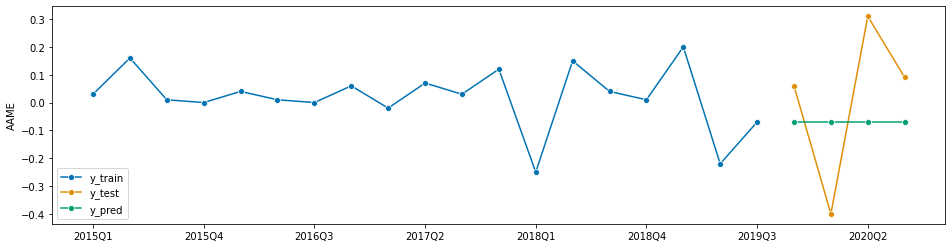

In [40]:
# using sktime naive
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

1.269219693589582

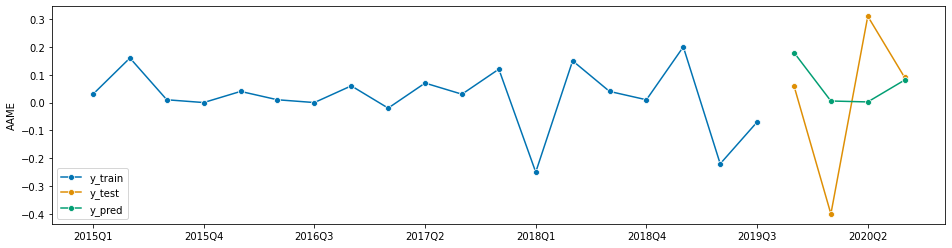

In [41]:
# using sktime arima
forecaster = ARIMA(order=(len(y_train)-1,2,0), suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

For the stock AAME, using ARIMA, we are able to predict the EPS slightly better than the naive model with a SMAPE score of 1.269219693589582 which is better than that of the naive model with SMAPE score of 1.851063829787234 

# Forecasting EPS and STD

In [ ]:
def window(col, ord):
    # y_train_old = y_train.copy()
#     ord = 8
    # y_train = y_train_old
    y_new = pd.DataFrame()
    for i in range(ord+1):
        y_new = pd.concat([y_new, col.shift(i)], axis = 1)

    X= y_new.dropna()
    y = X.iloc[:,-1]
    X = X.iloc[:,:-1]
    return X,y

In [ ]:
def old_method(col, ord):
    y_pred,std_window = [],[]
    X,y = window(col, ord)
    for idx,row in X.iterrows():
        lr = LinearRegression()
        lr.fit(np.arange(1,ord+1).reshape(-1,1), row)
        y_pred.append(lr.predict(y[idx].reshape(-1,1))[0])
        std_window.append(row.std())
#     print(f'y_pred:{y_pred},\nstd_window:{std_window}')
    return y_pred, std_window

# pred = pd.DataFrame(old_method(col,12), columns = col.index)

In [ ]:
def eps_pred_std(df, ord):
    std_pred = {}
    pred = {}
    for row,col in df.iteritems():
        pred[row], std_pred[row] = old_method(col,ord)

    df_pred = pd.DataFrame.from_dict(data =pred, orient = 'index', columns=df.index[ord:])
    df_std = pd.DataFrame.from_dict(data =std_pred, orient = 'index', columns=df.index[ord:])
    return df_pred, df_std
df_pred , df_std = eps_pred_std(df, 9)

In [ ]:
df_pred

In [ ]:
df_std.head()

In [ ]:
df_pred.to_csv("../dataset/df_pred.csv", index = False)
df_std.to_csv("../dataset/df_std.csv", index=False)